In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
import sys
sys.path.append('./modified_medsam_repo')
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from skimage import io, transform
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import nibabel as nib
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
import img2pdf
from torchmetrics import F1Score
import multiprocessing as mp

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.utils_hcp import *

In [2]:
cws = pickle.load(open('/gpfs/data/luilab/karthik/pediatric_seg_proj/class_weights_256.pkl', 'rb'))
darts_cws = pickle.load(open('/gpfs/data/luilab/karthik/pediatric_seg_proj/darts_class_wts_113_seg.pkl', 'rb'))

In [6]:
print(cws[0])

0.00027719847731247035


In [9]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

In [38]:
class_wts = np.zeros(NUM_CLASSES)
for k,v in cws.items():
    idx = label_converter.hcp_to_compressed(k).tolist()
    if idx == 0:
        class_wts[idx] = 0
    else:
        class_wts[idx] = v

print(class_wts)
#print(darts_cws)

[0.00000000e+00 1.96192695e-02 6.90481287e-01 2.17191599e+01
 3.07259310e-01 7.59494939e-02 5.02360694e-01 1.09473764e+00
 7.73031075e-01 2.95534604e+00 5.87551622e+00 2.65007390e+00
 1.98240083e-01 9.39117283e-01 2.64696240e+00 4.00610656e+00
 7.27196276e+00 9.90304444e-01 7.10702803e+01 3.25358918e+00
 1.93385475e-02 7.42879695e-01 2.00413272e+01 3.02458603e-01
 7.37634526e-02 5.65280237e-01 1.07759957e+00 7.55363292e-01
 2.84738139e+00 9.32205062e-01 2.52030099e+00 6.56790583e+00
 9.76089025e-01 6.18842038e+01 3.00515058e+00 1.81622270e+01
 4.39574706e+00 8.64013751e+00 8.32509768e+00 8.28915874e+00
 4.66266410e+00 2.08901773e+00 6.09711032e-01 1.26989975e+00
 2.39945633e+00 4.01776253e-01 3.25208599e-01 3.71507667e-01
 1.64736211e+00 3.60990347e-01 5.28703016e-01 5.95391520e-01
 7.72327871e-01 3.78220573e-01 1.93475310e+00 1.15358551e+00
 8.00223734e-01 1.91299483e+00 1.11501645e+00 1.56248495e+00
 4.14160176e-01 1.25486030e+00 2.99796314e-01 4.09212120e-01
 1.44112967e+00 2.488348

In [40]:
print(darts_cws)

[7.51475180e-02 6.83912420e-01 1.00348461e+01 4.43882402e-01
 1.60618419e-01 4.37561881e-01 1.22040101e+00 6.88786418e-01
 1.45532474e+00 4.37444997e+00 3.98217653e+00 4.64142466e-01
 1.07727160e+00 1.65615665e+00 2.43296808e+00 3.55379574e+00
 6.53154774e-01 1.08399476e+01 4.27308660e+00 7.44676543e-02
 7.28113796e-01 9.45299906e+00 4.44360121e-01 1.57696314e-01
 4.69238014e-01 1.17133627e+00 6.56058069e-01 1.35297664e+00
 1.10277773e+00 1.67429496e+00 2.94257216e+00 6.48534339e-01
 1.10185513e+01 4.11007227e+00 5.65254020e+00 1.00713364e+02
 4.87444062e+00 2.70104990e+00 3.17504892e+00 3.85808002e+00
 4.64177603e+00 3.17661127e+00 1.54432732e+01 1.07372684e+00
 2.06516831e+00 7.55800547e-01 1.56399827e+00 1.66273632e+00
 6.37319001e-01 5.35687723e-01 6.26002974e-01 2.23813926e+00
 5.58195700e-01 6.11444494e-01 5.74722537e-01 8.30699672e-01
 7.01241938e-01 1.93799603e+00 1.42662016e+00 9.20476693e-01
 1.15623259e+00 1.02482826e+00 1.42017571e+00 9.34541219e-01
 9.14986643e-01 7.619329

In [41]:
print(len(class_wts))
print(len(darts_cws))

103
113


Text(0, 0.5, 'DARTS weights')

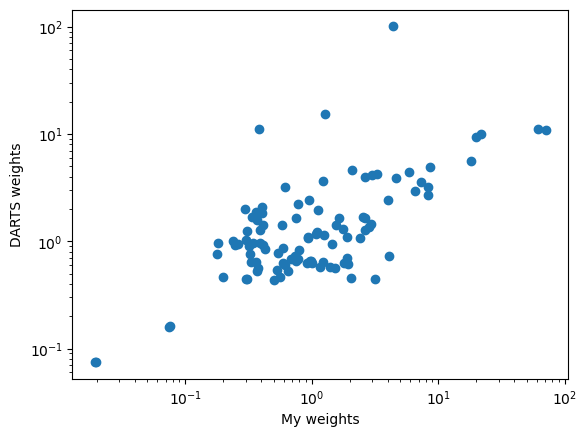

In [50]:
# plot them
plot_classwts = class_wts[1:] # ignore unknown
plot_dartswts = darts_cws[:102]

plt.scatter(plot_classwts, plot_dartswts)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('My weights')
plt.ylabel('DARTS weights')

In [54]:
darts_wts_as_my_format = darts_cws[:102].tolist()
darts_wts_as_my_format.insert(0, darts_cws[-1])

keys = list(range(len(darts_wts_as_my_format)))
hcp_mapped_keys = label_converter.compressed_to_hcp(keys)

dicto = dict()
for i in range(len(hcp_mapped_keys)):
    dicto[hcp_mapped_keys[i]] = darts_wts_as_my_format[i]

darts_wts_as_my_format = dicto
print(darts_wts_as_my_format)


{0: 0.0024084848957464417, 2: 0.07514751802272644, 4: 0.6839124203451645, 5: 10.034846056234555, 7: 0.4438824015576356, 8: 0.1606184185788448, 10: 0.4375618812708965, 11: 1.2204010112570236, 12: 0.6887864178343365, 13: 1.455324742881854, 14: 4.374449972142159, 15: 3.98217653469089, 16: 0.4641424655832906, 17: 1.0772715956166454, 18: 1.6561566538423598, 24: 2.4329680806888714, 26: 3.553795735312847, 28: 0.6531547737330343, 30: 10.839947577850804, 31: 4.273086595035555, 41: 0.07446765434097408, 43: 0.7281137955745122, 44: 9.452999055543795, 46: 0.44436012127426944, 47: 0.157696314455359, 49: 0.4692380143700335, 50: 1.1713362664131834, 51: 0.6560580694372679, 52: 1.352976635146644, 53: 1.1027777279414404, 54: 1.674294956773967, 58: 2.9425721602901813, 60: 0.6485343387147953, 62: 11.018551268072583, 63: 4.110072269217451, 85: 5.652540197295564, 251: 100.71336405529955, 252: 4.874440615362174, 253: 2.7010498954988567, 254: 3.175048917908118, 255: 3.8580800165337648, 1002: 4.641776031047087,

In [7]:

sum(list(cws.values()))

1830.678957847822

In [8]:
1830.679 / 130

14.082146153846155